# $&ensp&ensp$ ĐỒ ÁN KHAI THÁC DỮ LIỆU ỨNG DỤNG

### Thành viên

* Trần Đức Thắng - 1712761
* Nguyễn Lê Trường Thành - 1712775
* Đào Thanh Thiện - 1712782


In [14]:
import numpy as np
import pandas as pd
import re
from nltk import ngrams
from underthesea import word_tokenize
import os
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import torch
import transformers as ppb
import warnings


# XÂY DỰNG MÔ HÌNH ĐÁNH GIÁ ĐIỆN THOẠI QUA BÌNH LUẬN CỦA TRANG THEGIOIDIDONG.COM

## load data

In [15]:
warnings.filterwarnings('ignore')

In [16]:
# load data
def load_data_model(filepath, n, star):
    data = []
    with open(filepath, encoding="utf8") as fp:
        line = fp.readline()
        if line.strip().split(':')[0] == 'Name':
            name = line.strip().split(':')[1]
            
            temp = ''
        cnt = 1
        while line:
            #print("Line {}: {}".format(cnt, line.strip()))
            if line.strip().split(':')[0] == 'Name':
                name = line.strip().split(': ')[1]
                line = fp.readline()
            elif line.strip() == '':
                data.append([name, temp, n, star])
                temp = ''
            else:
                temp += ' ' + line.strip()
            line = fp.readline()
            #cnt += 1
    return pd.DataFrame(data, columns=['model', 'Text', 'Sentiment', 'Star'])

data1 = load_data_model('comment1.txt', 0, 1)
data2 = load_data_model('comment2.txt', 0, 2)
data3 = load_data_model('comment3.txt', 1, 3)
data4 = load_data_model('comment4.txt', 1, 4)
data5 = load_data_model('comment5.txt', 1, 5)
result = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

pd.set_option('display.max_colwidth',1000)

result

,model,Text,Sentiment,Star
0,Samsung Galaxy A71,"Dùng được 1 tháng thì sạc đến 95% là không lên nữa. Rút sạc ra cắm lại thì 100%, khônng hiểu.",0,1
1,Samsung Galaxy A71,Trời ơi làm ơn cho đổi máy khác đi mua mấy tháng giờ lỗi phần đánh thức buồn kg trôi.đưa đi kiểm tra rồi về vẫn bị a71 .là vậy sao làm ơn đôi máy khác đi,0,1
2,Samsung Galaxy A71,"Máy mua mới từ tháng 5/2020 Dùng được 3 tháng thì cắm sạc không vào ( điện thoại không rơi vào nước, không để nước vào ) Mang ra bảo hành thì báo lỗi cá nhân không được bảo hành thay mất 800k.",0,1
3,Samsung Galaxy A71,"Mang về dùng được 2 tháng nữa thì lại tiếp tục hỏng chân sạc ( củ sạc thường thì vào, sạc nhanh thì không lên ) lại lóc cóc mang ra bảo hành và được báo là chân sạc mốc lỗi cá nhân thay 640k",0,1
4,Samsung Galaxy A71,"Dùng bao nhiêu đời điện thoại của thegioididong rồi chưa bao giờ gặp tình trạng này, máy không rơi nước ko để nước vào 6 tháng hỏng sạc 2 lần máy mới nhưng không được bảo hành.",0,1
...,...,...,...,...
18013,Mobell M529,Sản phẩm nhỏ gọn thiết kế dẹp bàn phím lớn dễ thao tác màng hình to âm thanh to rõ chất lượng tốt pin khủng nhân viên phục vụ tốt và xinh tốt hơn mong đợi Minh tinh mua itell Nhưng chi nhánh hết hàng,1,5
18014,Mobell M529,Sản phẩm tốt. Mua làm quà cho người lớn thì 0k. Âm thanh nghe rõ. Phìm to dễ sử dụng,1,5
18015,Mobell M529,"Quá tuyệt vời. Điện thoại cơ bản mà tôi đang kiếm tìm bâdy lâu nay đây rồi. Pin trâu, màn to, phím lớn. Quá okê",1,5
18016,Mobell M529,Sản phẩm tuyệt vời. Mua làm quà cho người lớn thì tuyệt. Âm thanh nghe rõ. Phìm to dễ sử dụng. Thích,1,5


## histograms

<AxesSubplot:title={'center':'Top 10 điện thoại có nhiều comment nhất'}, xlabel='Số lượng comment', ylabel='Tên'>

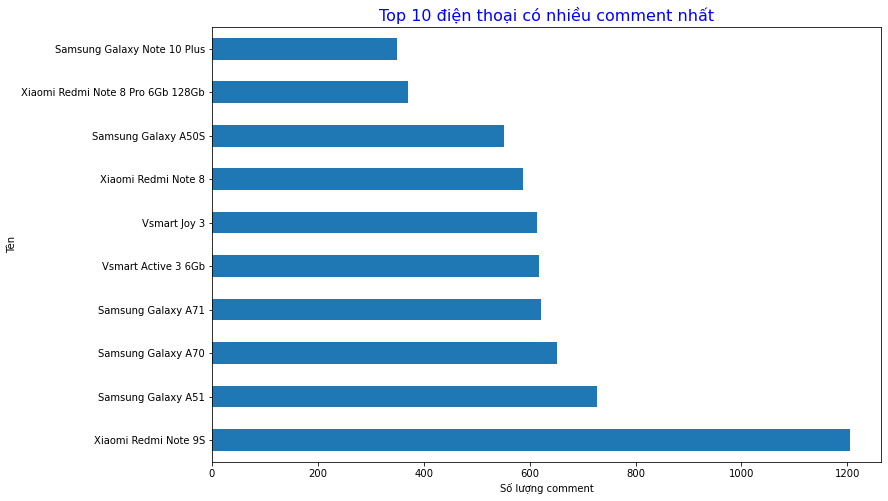

In [17]:
# Số lượng comment của từng điện thoại
totalCommentCount = result.model.value_counts()
mostComment = totalCommentCount.head(10)
plt.figure(figsize=(12, 8))
plt.xlabel("Số lượng comment")
plt.ylabel("Tên")
plt.title('Top 10 điện thoại có nhiều comment nhất'
          ,color = 'blue'
          ,fontsize = 16)
mostComment.plot.barh()

<AxesSubplot:title={'center':'Top 10 điện thoại có ít comment nhất'}, xlabel='Số lượng comment', ylabel='Tên'>

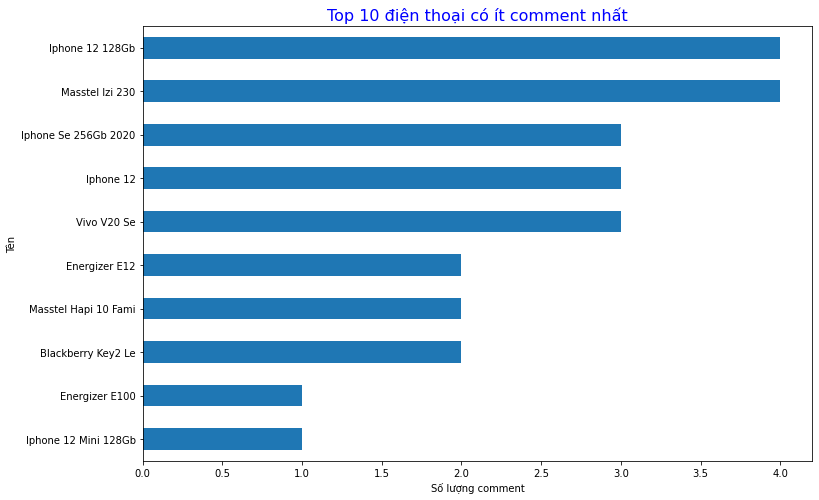

In [18]:
# Số lượng comment của từng điện thoại
totalCommentCount = result.model.value_counts()
lessComment = totalCommentCount[::-1].head(10)
plt.figure(figsize=(12, 8))
plt.xlabel("Số lượng comment")
plt.ylabel("Tên")
plt.title('Top 10 điện thoại có ít comment nhất'
          ,color = 'blue'
          ,fontsize = 16)
lessComment.plot.barh()

([<matplotlib.patches.Wedge at 0x1f149afde48>,
 [Text(-0.7191865894244864, 0.8323284505482048, 'Tích cực'),
  Text(0.7191866673526971, -0.8323283832130929, 'Tiêu cực')],
 [Text(-0.392283594231538, 0.4539973366626571, '72.7%'),
  Text(0.3922836367378348, -0.45399729993441423, '27.3%')])

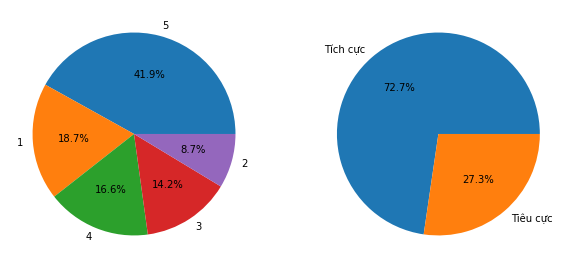

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

#Tỉ lệ comment theo sô sao
labels = result.Star.value_counts().index
sizes = result.Star.value_counts().values
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
#ax1.title('Tỉ lệ comment theo sô sao')

labels = ['Tích cực', 'Tiêu cực']
sizes = result.Sentiment.value_counts().values

ax2.pie(sizes, labels=labels, autopct='%1.1f%%')
#ax2.title('Tỉ lệ comment tích cực/ tiêu cực')

## Data pre-processing

In [25]:
# tách tập test từ dữ liệu
#test = result[(result.model == 'Xiaomi Redmi 9')] | (result.model == 'Realme 6')]
test = result[(result.model == 'Vsmart Joy 3')]
result = result.drop(test.index, axis=0)

In [27]:
emb = None

# Standardize text data
def standardize_data(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm than, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    # xóa số trong câu
    #row = re.sub(r'[0-9]+', '', row)
    row = row.strip()
    return row

# Tokenizer
def tokenizer(row):
    return word_tokenize(row, format="text")

# Embeding
def embedding(X_train, X_test):
    global  emb
    emb = TfidfVectorizer(min_df=5, max_df=0.8,max_features=3000,sublinear_tf=True)
    emb.fit(X_train)
    X_train =  emb.transform(X_train)
    X_test = emb.transform(X_test)

    # Save pkl file
    joblib.dump(emb, 'tfidf.pkl')
    # print(X_train, X_test)
    return X_train, X_test


In [28]:
# Standardize and tokenizer Text column
result["Text"] = result.Text.apply(standardize_data)

result["Text"] = result.Text.apply(tokenizer)

print(result["Text"][1])


Trời_ơi làm_ơn cho đổi máy khác đi mua mấy tháng giờ lỗi phần đánh_thức buồn kg trôi đưa đi kiểm_tra rồi về vẫn bị a71 là vậy sao làm_ơn đôi máy khác đi


In [36]:
# Convert to X_train, y_train
X_train,X_val,y_train,y_val = train_test_split(result["Text"],result["Sentiment"],test_size=0.2, random_state=42)

print("After preprocess data: ")
print(X_train)
print(y_train)

After preprocess data: 
12527                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Mình mới mua mấy luôn Máy chất_lượng pin trâu chụp hình đẹp oppo k làm tôi thất_vọng máy OK lắm
4221                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [37]:
# 4. Embeding X_train
X_train,X_val  = embedding(X_train, X_val)
print("Sau khi embedding data: ")
print(X_train[1])

Sau khi embedding data: 
  (0, 2870)	0.12586320538915355
  (0, 2839)	0.22937591263429716
  (0, 2816)	0.3345718403420745
  (0, 2438)	0.19516024269185245
  (0, 2205)	0.4076594970385036
  (0, 2159)	0.10828186034414235
  (0, 2067)	0.16538822978234177
  (0, 1956)	0.1559879310047141
  (0, 1769)	0.23474347627054384
  (0, 1397)	0.1268055609105711
  (0, 1389)	0.0950991760103874
  (0, 1297)	0.1933034477037231
  (0, 1252)	0.11443149320555074
  (0, 1157)	0.13457075478348016
  (0, 964)	0.2308087231128771
  (0, 794)	0.1312014369324001
  (0, 631)	0.1653120718002371
  (0, 630)	0.2827673969926453
  (0, 571)	0.1423118522297814
  (0, 523)	0.32795608079138727
  (0, 474)	0.2823480353136669
  (0, 447)	0.13350755011121695


In [31]:
# 5. Train and save model
model = svm.SVC(kernel='rbf', C = 1, gamma='scale')
model.fit(X_train,y_train)
joblib.dump(model, 'saved_model.pkl')


['saved_model.pkl']

In [32]:
# 6. Test
print("Model score=", model.score(X_val, y_val))

Model score= 0.8293593794886527


In [33]:
def analyze(result):
    bad = np.count_nonzero(result)
    good = len(result) - bad
    print("No of bad and neutral comments = ", bad)
    print("No of good comments = ", good)

    if good/(bad+good) > 0.8:
        return "Tốt, sản phẩm đáng mua!"
    else:
        return "Tệ, cần được xem xét kĩ trước khi mua!"

In [34]:
# Standardize and tokenizer Text column
test["Text"] = test.Text.apply(standardize_data)

test["Text"] = test.Text.apply(tokenizer)

# Embedding
emb = joblib.load('tfidf.pkl')
X_test  = emb.transform(test.Text)

#  Load weights
model = joblib.load('saved_model.pkl')

#  Result
rc = model.predict(X_test)

print(rc)
print(analyze(rc))

[0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0
 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0
 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

**Qua kết quả trên ta thấy có 461 comments tốt về sản phẩm, 152 comment xấu. Nên chúng ta cần kiểm tra kĩ trước khi mua nó**